## На сайте запущен А/В тест с целью увеличить доход.   
В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.  
### Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [114]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### считываем файл:

In [8]:
df = pd.read_excel('AB_Test_Results_homework.xlsx')
df.head()

C:\Users\lilly\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


#### анализ и проверка данных:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


файл содержит 10 000 строк  
нулевых значений нет  
типы данных соответствуют  
наименования корректные

In [10]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


### много нулевых значений (нет выручки на покупателя)

### рассмотрим отдельно тестовую и контрольную группу:

In [18]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [32]:
v = round(df.query('VARIANT_NAME == "variant"').count()[0] / df.VARIANT_NAME.count() * 100, 2)
c = round(df.query('VARIANT_NAME == "control"').count()[0] / df.VARIANT_NAME.count() * 100, 2)
v, c, v - c

(50.16, 49.84, 0.3199999999999932)

соотношение количества элементов 50,16% в тестовой группе (variant) и 49,84% в контрольной группе.  
разница между группами 0,32%.

In [16]:
df.query('VARIANT_NAME == "variant"').describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [17]:
df.query('VARIANT_NAME == "control"').describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


#### рапределение на графике:

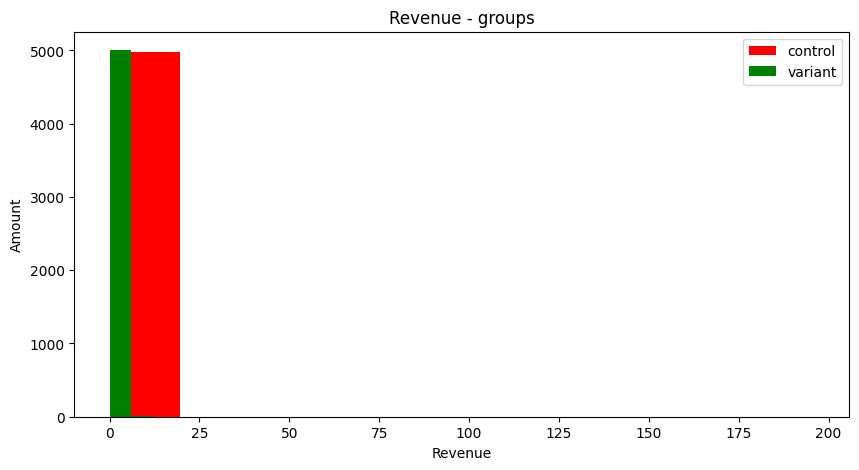

In [95]:
plt.figure(figsize=(10,5))

v = df['REVENUE'][df['VARIANT_NAME'] == 'variant']
c = df['REVENUE'][df['VARIANT_NAME'] == 'control']

plt.hist(c, color='r', bins=10)
plt.hist(v, color='g', bins=10)


plt.title('Revenue - groups')
plt.xlabel('Revenue')
plt.ylabel('Amount')
plt.legend(['control', 'variant'])

plt.show()

### исключаем все строки где выручка на покупателя равна меньше либо равна 0.

In [34]:
df_new = df.query('REVENUE > 0')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 13 to 9977
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       152 non-null    int64  
 1   VARIANT_NAME  152 non-null    object 
 2   REVENUE       152 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


In [36]:
df_new.describe()

,USER_ID,REVENUE
count,152.000000,152.000000
mean,4862.217105,6.542566
std,2987.566745,17.706752
min,56.000000,0.020000
25%,2177.250000,1.250000
50%,4980.500000,2.420000
75%,7393.250000,4.607500
max,9996.000000,196.010000


In [46]:
df_new.VARIANT_NAME.value_counts()

VARIANT_NAME
control    80
variant    72
Name: count, dtype: int64

In [132]:
v = round(df_new.query('VARIANT_NAME == "variant"').count()[0] / df_new.VARIANT_NAME.count() * 100, 2)
c = round(df_new.query('VARIANT_NAME == "control"').count()[0] / df_new.VARIANT_NAME.count() * 100, 2)
v, c, v - c

(47.37, 52.63, -5.260000000000005)

соотношение количества элементов 47,37% в тестовой группе (variant) и 52,63% в контрольной группе.  
разница между группами более 5%.

итого в выборке: variant 5016 - control 4984  
     с выручкой: variant 72 - control 80  
            
https://www.evanmiller.org/ab-testing/chi-squared.html - Chi-Squared Test 

Question: Does the rate of success differ across two groups?  

#### Verdict: No significant difference (p = 0.49)
Confidence level: 95%  

#### Значительных расхождений между группами нет, сплитование корректное, продолжаем анализ (ниже t Тест)

In [78]:
df_new.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,80.0,8.037500,22.498124,0.02,1.515,2.96,6.6575,196.01
variant,72.0,4.881528,9.913973,0.02,1.245,2.17,3.9725,58.63


In [54]:
df_new.query('VARIANT_NAME == "variant"').describe()

,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


In [50]:
df_new.query('VARIANT_NAME == "control"').describe()

,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


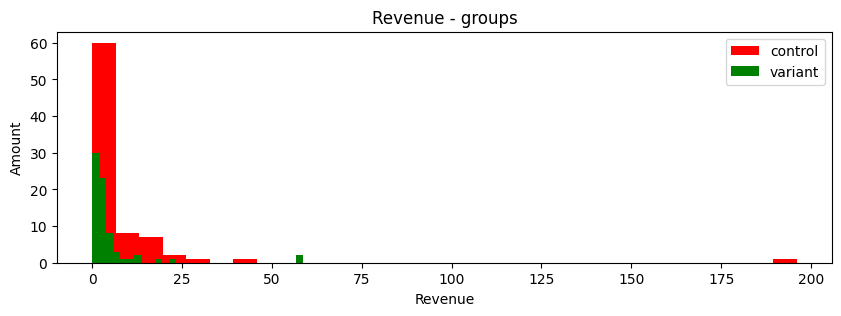

In [133]:
plt.figure(figsize=(10,3))

variant = df_new['REVENUE'][df_new['VARIANT_NAME'] == 'variant']
control = df_new['REVENUE'][df_new['VARIANT_NAME'] == 'control']

plt.hist(control, color='r', bins=30)
plt.hist(variant, color='g', bins=30)
plt.title('Revenue - groups')
plt.xlabel('Revenue')
plt.ylabel('Amount')
plt.legend(['control', 'variant'])

plt.show()

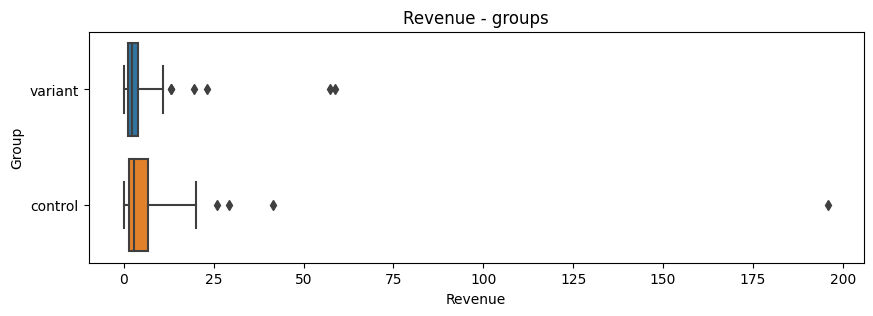

In [130]:
plt.figure(figsize=(10,3))
sns.boxplot(x = df_new['REVENUE'], y = df_new['VARIANT_NAME'], whis=3)
plt. title('Revenue - groups')
plt.xlabel('Revenue')
plt.ylabel('Group');

t тест:

In [209]:
stats.ttest_ind(variant, control, equal_var = False)

Ttest_indResult(statistic=-1.1379124979933528, pvalue=0.25760685398932337)

Verdict: No significant difference (p = 0.26)

Тип данных - количественные (выручка)  
Распределение - не нормальное  
Выборки независимые
Количество групп - 2

#### => критерий Манна-Уитни

- для выборки в целом:

In [207]:
mw = stats.mannwhitneyu(x=df[df['VARIANT_NAME'] == 'variant']['REVENUE'].values, 
                              y=df[df['VARIANT_NAME'] == 'control']['REVENUE'].values)
mw

MannwhitneyuResult(statistic=12478180.0, pvalue=0.47825247965294926)

- для выборки без нулевых значений выручки:

In [206]:
mw = stats.mannwhitneyu(x=df_new[df_new['VARIANT_NAME'] == 'variant']['REVENUE'].values, 
                              y=df_new[df_new['VARIANT_NAME'] == 'control']['REVENUE'].values)
mw

MannwhitneyuResult(statistic=2404.0, pvalue=0.07924299810603061)

При первичном рассмотрении статистически значимых разниц между двумя группами нет (уровень статистической значимости 5%).  
Значения pValue по вариантам фильтрации выборок:  
- 0.48 для выборки в целом;
- 0.08 для выборки без нулевых значений  
  оба > уровня значимости

### В выборках присутствуют выбросы. Проанализируем выборки исключая выбросы.

In [184]:
group_v = df_new.query('VARIANT_NAME == "variant"')
group_c = df_new.query('VARIANT_NAME == "control"')

In [150]:
def q1 (x):
    return x.quantile(0.25)

def q3 (x):
    return x.quantile(0.75)

рассчитаем квартили Q1, Q3 и интерквартильное расстояние:

In [156]:
q1_v = group_v['REVENUE'].agg(q1)
q3_v = group_v['REVENUE'].agg(q3)
iqr_v = q3_v - q1_v
q1_v,q3_v, iqr_v

(1.245, 3.9725, 2.7275)

In [157]:
q1_c = group_c['REVENUE'].agg(q1)
q3_c = group_c['REVENUE'].agg(q3)
iqr_c = q3_c - q1_c
q1_c,q3_c, iqr_c

(1.5150000000000001, 6.6575, 5.1425)

рассчитаем два варианта выбросов:  
- (внутренние границы = незначительные выбросы, коэффициент 1,5 (minor));
- (внешние границы = значительные выбросы, коэффициент 3 (major)).

In [200]:
minor_outlier_v = [q1_v - 1.5 * iqr_v, q3_v + 1.5 * iqr_v]
major_outlier_v = [q1_v - 3 * iqr_v, q3_v + 3 * iqr_v]

minor_outlier_c = [q1_c - 1.5 * iqr_c, q3_c + 1.5 * iqr_c]
major_outlier_c = [q1_c - 3 * iqr_c, q3_c + 3 * iqr_c]

minor_outlier_v, major_outlier_v, minor_outlier_c, major_outlier_c

([-2.8462500000000004, 8.06375],
 [-6.937500000000001, 12.155000000000001],
 [-6.19875, 14.37125],
 [-13.9125, 22.085])

фильтруем группы исходя из полученных границ:  
- minor - данные за исключением значительных и незначительных выбросов
- major - данные за исключением только значительных выбросов.

In [191]:
group_v_minor = group_v[(group_v['REVENUE'] >= minor_outlier_v[0]) & (group_v['REVENUE'] <= minor_outlier_v[1])]
group_v_major = group_v[(group_v['REVENUE'] >= major_outlier_v[0]) & (group_v['REVENUE'] <= major_outlier_v[1])]


group_c_minor = group_c[(group_c['REVENUE'] >= minor_outlier_c[0]) & (group_c['REVENUE'] <= minor_outlier_c[1])]
group_c_major = group_c[(group_c['REVENUE'] >= major_outlier_c[0]) & (group_c['REVENUE'] <= major_outlier_c[1])]

### Minor (незначительные)

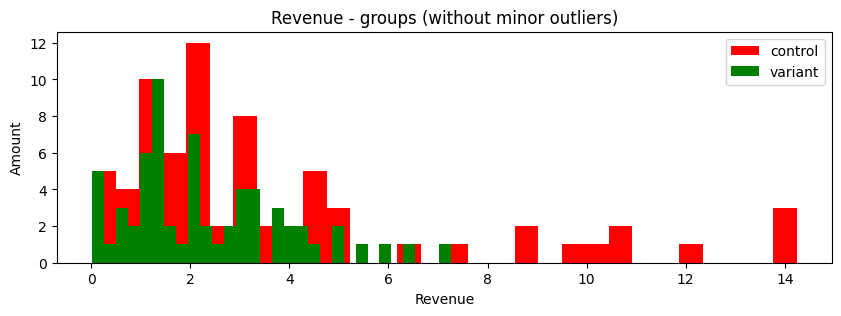

In [195]:
plt.figure(figsize=(10,3))

plt.hist(group_c_minor['REVENUE'], color='r', bins=30)
plt.hist(group_v_minor['REVENUE'], color='g', bins=30)
plt.title('Revenue - groups (without minor outliers)')
plt.xlabel('Revenue')
plt.ylabel('Amount')
plt.legend(['control', 'variant'])

plt.show()

In [210]:
mw = stats.mannwhitneyu(x=group_v_minor['REVENUE'].values, 
                              y=group_c_minor['REVENUE'].values)
mw

MannwhitneyuResult(statistic=1829.0, pvalue=0.0510977588359722)

#### Значение pValue = 0.05, что практически равно уровню статистической значисмости.  

In [217]:
#stats.ttest_ind(group_v_minor['REVENUE'].values, group_c_minor['REVENUE'].values, equal_var = False)

Ttest_indResult(statistic=-2.8825740351225826, pvalue=0.00481185645846028)

### Major (значительные)

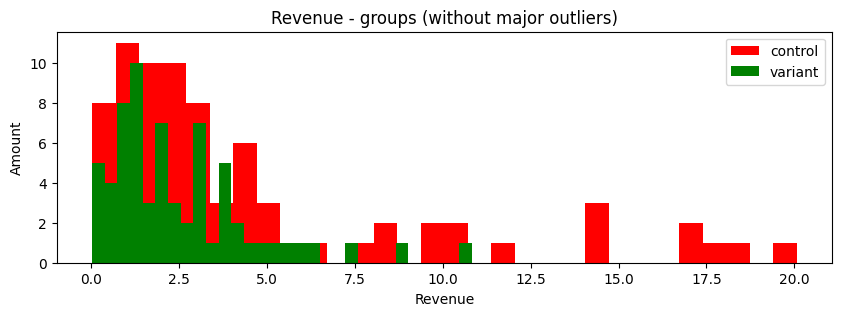

In [196]:
plt.figure(figsize=(10,3))

plt.hist(group_c_major['REVENUE'], color='r', bins=30)
plt.hist(group_v_major['REVENUE'], color='g', bins=30)
plt.title('Revenue - groups (without major outliers)')
plt.xlabel('Revenue')
plt.ylabel('Amount')
plt.legend(['control', 'variant'])

plt.show()

In [211]:
mw = stats.mannwhitneyu(x=group_v_major['REVENUE'].values, 
                              y=group_c_major['REVENUE'].values)
mw

MannwhitneyuResult(statistic=1959.0, pvalue=0.02481907324268117)

In [218]:
#stats.ttest_ind(group_v_major['REVENUE'].values, group_c_major['REVENUE'].values, equal_var = False)

Ttest_indResult(statistic=-3.314510398602977, pvalue=0.0012653908571572177)

#### Значение pValue = 0.02 - выборки, при условии исключения значительных выбросов отличаются   
#### (при уровне статистической значимости 5%)

In [216]:
means = [group_v_major['REVENUE'].mean(), group_c_major['REVENUE'].mean()]
means

[2.528636363636363, 4.607368421052632]

In [219]:
stds = [group_v_major['REVENUE'].std(), group_c_major['REVENUE'].std()]
stds

[2.0959395810167636, 4.983432382985593]

In [222]:
counts = [group_v_major['REVENUE'].count(), group_c_major['REVENUE'].count()]
counts

[66, 76]

### ВЫВОДЫ:

изменения не выкатывать так как показатели контрольной группы лучше чем тестовой.  
Для принятия решения использованы расчеты по выборкам без значительных выбросов.  

Расчеты по выборкам итого показали что группы аналогичны и сплитованы верно.  
Группы без учета покупателей, выручка по которым = 0, также сопоставимы.  

Расчеты показали наличие выбросов, как значительных, так и нет.  
Для очистки выборок от незначительных выбросов нужны основания/комментарии по данным.  
Поэтому расчет произведен именно по выборкам без значительных выбросов.